### Import necessary libraries

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

### Import Dependencies


In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
from collections import deque
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from base64 import b64encode
from IPython.display import HTML, display
import os


if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

### Loading CartPole Environment

In [3]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)

# Inside Box([min], [max])
# min[cart_position, cart_velovity, pole_angle, angular_velocity]
# max[cart_position, cart_velovity, pole_angle, angular_velocity]

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


### Initial Observation

In [4]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.04082834 -0.02559415  0.03816619  0.0494167 ]


In [5]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.0003786   0.02575625  0.0303135  -0.02077067]


In [6]:
# Always Choose zero strategy
def printInfo(observation, reward, done):
    print("New observations after choosing action 0:", observation)
    print("Reward for this step:", reward)
    print("Is this round done?:", done)
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    printInfo(observation, reward, done)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

New observations after choosing action 0: [ 0.00810781 -0.21453261  0.03639051  0.2598599 ]
Reward for this step: 1.0
Is this round done?: False
New observations after choosing action 0: [ 0.00381716 -0.41015464  0.0415877   0.56379515]
Reward for this step: 1.0
Is this round done?: False
New observations after choosing action 0: [-0.00438593 -0.6058347   0.05286361  0.8692847 ]
Reward for this step: 1.0
Is this round done?: False
New observations after choosing action 0: [-0.01650263 -0.80163443  0.0702493   1.1781087 ]
Reward for this step: 1.0
Is this round done?: False
New observations after choosing action 0: [-0.03253531 -0.99759483  0.09381147  1.4919606 ]
Reward for this step: 1.0
Is this round done?: False
New observations after choosing action 0: [-0.05248721 -1.193725    0.12365068  1.8124022 ]
Reward for this step: 1.0
Is this round done?: False
New observations after choosing action 0: [-0.07636171 -1.3899885   0.15989873  2.1408107 ]
Reward for this step: 1.0
Is this roun

### Task 1: Development of Deep Q-Learning Based RL Agent

### Defining DQN Class

In Pytorch, all neural network models should inherit from nn.module

DQN attributes:

*   in_states: the number of input features (or state dimensions)
*   h1_nodes: the number of nodes in the hidden layer
*   out_actions: the number of output actions (or outputs)
*   fc1 is a first fully connected (linear) layer mapping inpt states to the hidden layer
*   out is another fully connected layer mapping the hidden layer to the output actions


DQN's forward function:  

*   refers to the neural network's process of taking a state as input and outputting a vector of Q-values (predicted action values) for each possible action in that state.
*  self.fc1(x) refers to passing the data through the first layer called self.fc1
*   F.relu refers to applying rectified linear unit (ReLU) activation
*   self.out(x) means pass the data to the output layer to produce the final output






In [7]:

class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()
        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        # self.fc1(x) means passing the data through the first layer called self.fc1
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        # the data is then passed to the output layer to produce the final output
        x = self.out(x)         # Calculate output
        return x


### Define memory for Experience Replay

In [8]:
# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        # maxlen is the maximum number of transitions that the memory can hold
        # from here it means using a deque from python collections module
        # the deque is initialized with an empty list and maximum length
        # when the memory is full and new transition is added, then the oldest transition will be automatically removed
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        #transition, this could be a tuple that contains state, action, reward, and next state
        self.memory.append(transition)

    def sample(self, sample_size):
        # randome.sample() is to select a specified number of transitions from the stored memory
        # once selected, the transition will not be selected again
        # this is to break the temporal correlation.
        # in reinforcement learning, consecutive experiences are usually highly correlated (the agent state at one time step is similar to the next )
        # using this consecutive experiences can lead the model to overfit to certain events
        # with this random sampling, it breaks the temporal correlaton, thereby prevent overfitting
        # ensure that the training batches are more diverse
        # this diversity helps to stabilize the learning process and avoid divergence or oscillations during training
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [9]:
class DQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define Replay Memory for Experience Replay
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        # transition is a tuple (state, action, reward, next_state, done)
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [10]:
# Training function for Deep Q-Learning on CartPole-v1
def train_dqn_agent(
    env,
    episodes=500,
    max_steps=500,
    batch_size=64,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    lr=0.001,
    target_update_freq=10,
    memory_capacity=10000
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = env.observation_space.shape[0]   # CartPole has 4 continuous state values
    output_dim = env.action_space.n                # Two actions: 0 and 1
    hidden_dim = 64                                # You can adjust the hidden layer size

    # Initialize policy and target networks
    policy_net = DQN(input_dim, hidden_dim, output_dim).to(device)
    target_net = DQN(input_dim, hidden_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(memory_capacity)

    epsilon = epsilon_start
    rewards_history = []

    for episode in range(episodes):
        state = env.reset()
        # If reset() returns a tuple (observation, info), extract the observation.
        if isinstance(state, tuple):
            state = state[0]
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cumulative_reward = 0

        for t in range(max_steps):
            # ε-greedy action selection:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    action = q_values.argmax().item()

            # Updated unpacking for gym v0.25.0+ (returns terminated and truncated)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            cumulative_reward += reward

            # If next_state is returned as a tuple, extract the observation
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push((state, action, reward, next_state_tensor, done))
            state = next_state_tensor

            # Learning step if enough transitions are available
            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.cat(batch_state)
                batch_action = torch.tensor(batch_action, dtype=torch.int64, device=device).unsqueeze(1)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32, device=device).unsqueeze(1)
                batch_next_state = torch.cat(batch_next_state)
                batch_done = torch.tensor(batch_done, dtype=torch.float32, device=device).unsqueeze(1)

                # Compute Q(s, a) using the policy network
                current_q = policy_net(batch_state).gather(1, batch_action)
                # Compute maximum Q value for the next state from the target network
                next_q = target_net(batch_next_state).max(1)[0].detach().unsqueeze(1)
                # Compute target Q values
                expected_q = batch_reward + gamma * next_q * (1 - batch_done)

                # Compute loss (mean squared error)
                loss = F.mse_loss(current_q, expected_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        # Decay epsilon and record reward
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards_history.append(cumulative_reward)

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}: Reward = {cumulative_reward:.2f}, Epsilon = {epsilon:.2f}")

        # Update the target network periodically
        if (episode + 1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

    return policy_net, rewards_history

Episode 10: Reward = 23.00, Epsilon = 0.95
Episode 20: Reward = 14.00, Epsilon = 0.90
Episode 30: Reward = 15.00, Epsilon = 0.86
Episode 40: Reward = 17.00, Epsilon = 0.82
Episode 50: Reward = 38.00, Epsilon = 0.78
Episode 60: Reward = 16.00, Epsilon = 0.74
Episode 70: Reward = 13.00, Epsilon = 0.70
Episode 80: Reward = 20.00, Epsilon = 0.67
Episode 90: Reward = 31.00, Epsilon = 0.64
Episode 100: Reward = 41.00, Epsilon = 0.61
Episode 110: Reward = 100.00, Epsilon = 0.58
Episode 120: Reward = 11.00, Epsilon = 0.55
Episode 130: Reward = 16.00, Epsilon = 0.52
Episode 140: Reward = 48.00, Epsilon = 0.50
Episode 150: Reward = 189.00, Epsilon = 0.47
Episode 160: Reward = 154.00, Epsilon = 0.45
Episode 170: Reward = 19.00, Epsilon = 0.43
Episode 180: Reward = 277.00, Epsilon = 0.41
Episode 190: Reward = 173.00, Epsilon = 0.39
Episode 200: Reward = 334.00, Epsilon = 0.37
Episode 210: Reward = 165.00, Epsilon = 0.35
Episode 220: Reward = 232.00, Epsilon = 0.33
Episode 230: Reward = 134.00, Eps

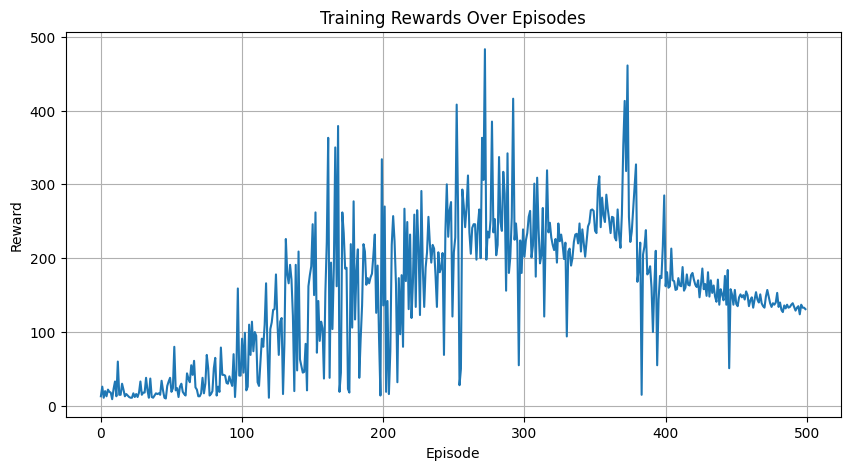

Evaluation Episode 1: Reward = 135.0
Evaluation Episode 2: Reward = 128.0
Evaluation Episode 3: Reward = 130.0
Evaluation Episode 4: Reward = 128.0
Evaluation Episode 5: Reward = 133.0
Evaluation Episode 6: Reward = 144.0
Evaluation Episode 7: Reward = 130.0
Evaluation Episode 8: Reward = 139.0
Evaluation Episode 9: Reward = 140.0
Evaluation Episode 10: Reward = 134.0
Average Reward over 10 evaluation episodes: 134.10


In [11]:
# Helper function to perform a step and unpack based on API version.
def step_env(env, action):
    result = env.step(action)
    # If 4 values, legacy gym: (next_state, reward, done, info)
    if len(result) == 4:
        next_state, reward, done, info = result
    # If 5 values, new gym API: (next_state, reward, terminated, truncated, info)
    elif len(result) == 5:
        next_state, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:
        raise ValueError("Unexpected number of values returned from env.step()")
    return next_state, reward, done, info

# Training function for Deep Q-Learning on CartPole-v1
def train_dqn_agent(
    env,
    episodes=500,
    max_steps=500,
    batch_size=64,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    lr=0.001,
    target_update_freq=10,
    memory_capacity=10000
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = env.observation_space.shape[0]   # CartPole has 4 continuous state values
    output_dim = env.action_space.n                # Two actions: 0 and 1
    hidden_dim = 64                                # You can adjust the hidden layer size

    # Initialize policy and target networks
    policy_net = DQN(input_dim, hidden_dim, output_dim).to(device)
    target_net = DQN(input_dim, hidden_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(memory_capacity)

    epsilon = epsilon_start
    rewards_history = []

    for episode in range(episodes):
        # Use return_info=True to ensure we get the observation (if supported)
        result = env.reset(return_info=True)
        if isinstance(result, tuple):
            state = result[0]
        else:
            state = result
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cumulative_reward = 0

        for t in range(max_steps):
            # ε-greedy action selection:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    action = q_values.argmax().item()

            next_state, reward, done, info = step_env(env, action)
            cumulative_reward += reward

            # If next_state is a tuple, extract the observation.
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory.
            memory.push((state, action, reward, next_state_tensor, done))
            state = next_state_tensor

            # Perform a learning step if enough transitions are available.
            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.cat(batch_state)
                batch_action = torch.tensor(batch_action, dtype=torch.int64, device=device).unsqueeze(1)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32, device=device).unsqueeze(1)
                batch_next_state = torch.cat(batch_next_state)
                batch_done = torch.tensor(batch_done, dtype=torch.float32, device=device).unsqueeze(1)

                # Compute Q(s, a) using the policy network.
                current_q = policy_net(batch_state).gather(1, batch_action)
                # Compute maximum Q value for the next state from the target network.
                next_q = target_net(batch_next_state).max(1)[0].detach().unsqueeze(1)
                # Compute target Q values.
                expected_q = batch_reward + gamma * next_q * (1 - batch_done)

                # Compute loss (mean squared error).
                loss = F.mse_loss(current_q, expected_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        # Decay epsilon and record reward.
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards_history.append(cumulative_reward)

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}: Reward = {cumulative_reward:.2f}, Epsilon = {epsilon:.2f}")

        # Update the target network periodically.
        if (episode + 1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

    return policy_net, rewards_history

# Evaluation function for the trained DQL agent
def evaluate_dqn_agent(env, policy_net, episodes=10, max_steps=500):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net.eval()
    rewards = []

    for episode in range(episodes):
        result = env.reset(return_info=True)
        if isinstance(result, tuple):
            state = result[0]
        else:
            state = result
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cumulative_reward = 0

        for t in range(max_steps):
            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.argmax().item()
            next_state, reward, done, info = step_env(env, action)
            cumulative_reward += reward
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            if done:
                break
        rewards.append(cumulative_reward)
        print(f"Evaluation Episode {episode+1}: Reward = {cumulative_reward}")

    avg_reward = np.mean(rewards)
    print(f"Average Reward over {episodes} evaluation episodes: {avg_reward:.2f}")
    return rewards

# Main execution: Train and evaluate the DQL agent
env_train = gym.make("CartPole-v1")
policy_net, training_rewards = train_dqn_agent(env_train, episodes=500)
env_train.close()

plt.figure(figsize=(10,5))
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Rewards Over Episodes")
plt.grid(True)
plt.show()

env_eval = gym.make("CartPole-v1")
evaluation_rewards = evaluate_dqn_agent(env_eval, policy_net, episodes=10)
env_eval.close()


Solved at episode 251 with reward 500.0!


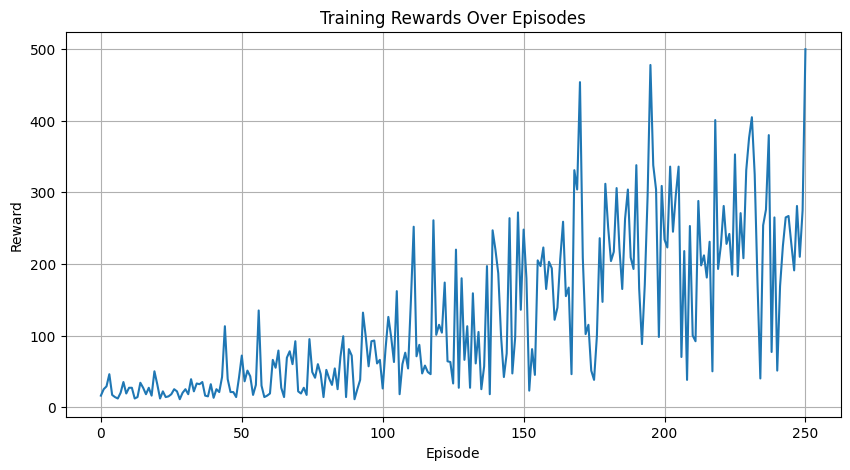

Evaluation Episode 1: Reward = 328.0
Evaluation Episode 2: Reward = 242.0
Evaluation Episode 3: Reward = 253.0
Evaluation Episode 4: Reward = 244.0
Evaluation Episode 5: Reward = 225.0
Evaluation Episode 6: Reward = 233.0
Evaluation Episode 7: Reward = 214.0
Evaluation Episode 8: Reward = 231.0
Evaluation Episode 9: Reward = 220.0
Evaluation Episode 10: Reward = 267.0
Average Reward over 10 evaluation episodes: 245.70


In [12]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# Define the Deep Q-Network (DQN)
class DQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define Replay Memory for Experience Replay
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        # transition is a tuple (state, action, reward, next_state, done)
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Helper function to perform a step and unpack based on API version.
def step_env(env, action):
    result = env.step(action)
    # If 4 values, legacy gym: (next_state, reward, done, info)
    if len(result) == 4:
        next_state, reward, done, info = result
    # If 5 values, new gym API: (next_state, reward, terminated, truncated, info)
    elif len(result) == 5:
        next_state, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:
        raise ValueError("Unexpected number of values returned from env.step()")
    return next_state, reward, done, info

# Training function for Deep Q-Learning on CartPole-v1 that runs until an episode gets 500 reward.
def train_dqn_until_solved(
    env,
    max_steps=500,
    batch_size=64,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    lr=0.001,
    target_update_freq=10,
    memory_capacity=10000,
    max_episodes=100000  # safeguard to avoid infinite loops
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = env.observation_space.shape[0]   # CartPole has 4 continuous state values
    output_dim = env.action_space.n                # Two actions: 0 and 1
    hidden_dim = 64                                # Hidden layer size

    # Initialize policy and target networks
    policy_net = DQN(input_dim, hidden_dim, output_dim).to(device)
    target_net = DQN(input_dim, hidden_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(memory_capacity)

    epsilon = epsilon_start
    rewards_history = []

    for episode in range(max_episodes):
        # Use return_info=True to ensure we get the observation (if supported)
        result = env.reset(return_info=True)
        state = result[0] if isinstance(result, tuple) else result
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cumulative_reward = 0

        for t in range(max_steps):
            # ε-greedy action selection:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    action = q_values.argmax().item()

            next_state, reward, done, info = step_env(env, action)
            cumulative_reward += reward

            # If next_state is a tuple, extract the observation.
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory.
            memory.push((state, action, reward, next_state_tensor, done))
            state = next_state_tensor

            # Perform a learning step if enough transitions are available.
            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.cat(batch_state)
                batch_action = torch.tensor(batch_action, dtype=torch.int64, device=device).unsqueeze(1)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32, device=device).unsqueeze(1)
                batch_next_state = torch.cat(batch_next_state)
                batch_done = torch.tensor(batch_done, dtype=torch.float32, device=device).unsqueeze(1)

                # Compute Q(s, a) using the policy network.
                current_q = policy_net(batch_state).gather(1, batch_action)
                # Compute maximum Q value for the next state from the target network.
                next_q = target_net(batch_next_state).max(1)[0].detach().unsqueeze(1)
                # Compute target Q values.
                expected_q = batch_reward + gamma * next_q * (1 - batch_done)

                # Compute loss (mean squared error).
                loss = F.mse_loss(current_q, expected_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        # Decay epsilon and record reward.
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards_history.append(cumulative_reward)

        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode+1}: Reward = {cumulative_reward:.2f}, Epsilon = {epsilon:.2f}")

        # Update the target network periodically.
        if (episode + 1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Check if the agent achieved a reward of 500, and if so, stop training.
        if cumulative_reward >= max_steps:
            print(f"Solved at episode {episode+1} with reward {cumulative_reward}!")
            break

    return policy_net, rewards_history

# Evaluation function for the trained DQN agent
def evaluate_dqn_agent(env, policy_net, episodes=10, max_steps=500):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net.eval()
    rewards = []

    for episode in range(episodes):
        result = env.reset(return_info=True)
        state = result[0] if isinstance(result, tuple) else result
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        cumulative_reward = 0

        for t in range(max_steps):
            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.argmax().item()
            next_state, reward, done, info = step_env(env, action)
            cumulative_reward += reward
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            if done:
                break
        rewards.append(cumulative_reward)
        print(f"Evaluation Episode {episode+1}: Reward = {cumulative_reward}")

    avg_reward = np.mean(rewards)
    print(f"Average Reward over {episodes} evaluation episodes: {avg_reward:.2f}")
    return rewards

# Main execution: Train and evaluate the DQN agent until solved
env_train = gym.make("CartPole-v1")
policy_net, training_rewards = train_dqn_until_solved(env_train)
env_train.close()

plt.figure(figsize=(10,5))
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Rewards Over Episodes")
plt.grid(True)
plt.show()

env_eval = gym.make("CartPole-v1")
evaluation_rewards = evaluate_dqn_agent(env_eval, policy_net, episodes=10)
env_eval.close()
